```
                            (#%(//***,.                                         
                          %@&&&&&&&&%&&&&&&#                                    
                       ,@@@@@&&%#(/*,,*(#%&&@&. ,#%&&&&&@&&#,                   
                      %&@@@@&&%(*,.....,*(#%&&@&&@@@@@&%&&@@@@@@@&              
                     /%@&@@@&%%(/******/(##%&&@@&@@&#((////(((#%&@@@@           
            /&@@@@@@&%@@@&@@&%%###(((#%%%&&&&&&&##%&#///*/(&@@@&%%&@@@#         
        (@@@@&/@@@@@@@@#%@@@@&&%%%%*/#&%#%&&&@@@@@@&#//&%                       
      @@@&&((##(%&@@@@@@&%@%@&@(%#%%%%%%,./(/.(/&((&@.                          
    &@@%//***,****(#%&@@@@@@@@%&*/#/.*(///*,//.#%%,&                            
   &@@(/**,,,,,,,,,,/&&@@@@@@@@&. ((/  /#%####%&&&(&                            
  &@@#(#%@@@&*        %@@@@@@@@&*#%&/%((((%&&%%&&@@&                            
 .@@@@@                   (#&&&&@@@@&&&//,,,(/(##/                             ,
 .@&                      %@@&&(%(,*(/,..*(#/(%#((#%(.                       ,.@
  .                   .(&%&@@@&%##**(#@/,  %@%%@#/#,%&&&                    ,.@@
                  *%&@@&(/#%&@&@@@#(.. .,,*/*&@@@///,%%&@%                 ,.@@@
                &@@@&&&%&@*,(#@@&@@@@@@(. ,&@&%@@&(,%,&&@@/              .,(@@@@
               &@@%%(/#%&@@,,*(%@%@@@@@@@&##/(%&&%&#/#&@@@&           ..*.@@@@@@
               @@@&%%%&&&@@@,%,&%&&&@@&%((&(%&@@@@%@#&&&&&@&.        ..*,@@@@@@@
               #@@@&%(((%&&@%#,(%%@@&@&%*@@@@@@@@@@@%@&&/(#&&*...  ...*,@@@@@@@@
               .%&&&(  ,(%&&@&*(&&&&&%/,&@&(@@&%&@@@&@@@&**#&&&,. ../*(@@@@@@@@&
         .......%&@@@&&&@@@@@&/&&&%%#/(&@&(%%@%%%%@&@&&@@&&./#%%* ./*&@@@@@@@@@@
##############(,*@@&&&&&&&@@@&&@@@@&#*#&&@&#%&%%#%%%@@&%@&&&#,(%&%*/@@@@@@@@@@@@
##############(*.@@@%%#&&&@@@&@&%#(*#&@&#(#&&%&&##(,%&&&%%&@&&&@%/&@@@@@@@@@@@@@
((##########(((/.%@@@#(#%&&@&&&%(*,(#%%&&(%#%#%&%#(,.#%&@@&@(,,%*#@@@@@@@@@@@@@@
//(##########(,...@@@@@&&%@@&&%#((#%&&&%&%%&%%%&&%    ##%&@@@@/*&%@@@@@@@@@@@@@@
(###########((/,,.(@@@&/,(@&&&&%%&&&&&%%&&&%%%%&&........%%%%**@@@@@@@@&@@@@@@@@
###(,,,,*/(((((*,(%@@@@@@@@&&&&&&&@&%/&&%#%%%%&&#./#(*//(((%*/@@@@@@@@@@@@@@@@@@
,*###(((((((((((#&&@@&@@@@&@@&&@@&&(&#**,**,,,********//((%*#@@@@@@@@@@@@@@@@@@@
///////////////(#%&&@@&@@@@@@@@@&(**,*,,,,,,,,,*%//%##(##(*&@@@@@@@@@@@@@@@@@@@@
///////////////////(##%&@@@@@@@&%******&/(##%###########/*@@@@@@@@@@@@@@@@@@@@@@
////////////////////((#%%%%&@@@&&#,(/#%*,*/*.&%########//@@@@@@@@@@@@@@@@@@@@@@&
%%(*/////////////////////(///////#@@@@@@@@/(%*,*/(.,&&*(@@@@@@@@@@@@@@@@@@@@@@(/
```
# Goblin Mode

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [55]:
import os
import torch
import cv2
import copy
import torch.nn as nn
import numpy as np
import json 
import mediapipe as mp
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output, Image
from models.fnn import PoseFFNN, get_accuracy, train
from helper import plot, get_pose_names, center_chest
from dataloader.dataloader import load_data, PoseLoader
from confusion_matrix import get_confusion_matrix, print_worst_cm

os.environ['MEDIAPIPE_BACKEND'] = 'gpu'

In [3]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
mediaPipe = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

In [4]:
# Get a list of all the pose names
poses = get_pose_names()

# Load the pose data by type
rawTrain, rawVal, rawTest = load_data(poses, type='raw')

# Data is loaded in batches and labels are one-hot encoded
train_data = PoseLoader(rawTrain, 'train', oneHot=True)
val_data = PoseLoader(rawVal, 'val', oneHot=True)
test_data = PoseLoader(rawTest, 'test', oneHot=True)

In [100]:
def go_nuts():

    best_model, best_val_acc = None, 0
    best_lr, best_L2_reg, best_batch_size = None, None, None

    # Define hyperparameter ranges for grid search
    lr_range = [0.001, 0.003, 0.006]
    L2_reg_range = [0.0001, 0.0003, 0.0006]
    batch_size_range = [8, 16, 32, 64]
    seed = 42
    
    all_val_accs = {}
    for lr in lr_range:
        all_val_accs[lr] = {}
        for L2_reg in L2_reg_range:
            all_val_accs[lr][L2_reg] = {}
            for batch_size in batch_size_range:

                print(f'lr : {lr} | l2 : {L2_reg} | bs : {batch_size}')

                torch.manual_seed(seed)

                # Define your model
                model = PoseFFNN(input_dim=69, output_dim=82)

                # Set up your optimizer
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=L2_reg)

                # Set up your loss function
                criterion = nn.CrossEntropyLoss()

                epochs = 75
                train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
                model, this_val_acc = train(model, train_loader, val_data, optimizer, criterion, epochs, batch_size)

                all_val_accs[lr][L2_reg][batch_size] = this_val_acc

                if this_val_acc > best_val_acc:
                    best_val_acc = this_val_acc
                    best_model = copy.deepcopy(model)
                    best_lr = lr
                    best_L2_reg = L2_reg
                    best_batch_size = batch_size

    print('Best Hyperparameters')
    print('learning rate :', best_lr)
    print('weight decay :', best_L2_reg)
    print('batch size :', best_batch_size)
    print()

    return best_model, all_val_accs

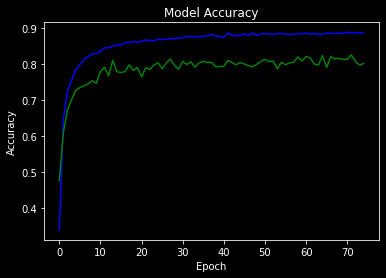

100%|██████████| 75/75 [05:22<00:00,  4.30s/it]

Epoch 75/75 | Training accuracy: 0.8878 | Validation accuracy: 0.8017
Best Hyperparameters
learning rate : 0.003
weight decay : 0.0003
batch size : 32



In [101]:
model, all_val_accs = go_nuts()

In [102]:
with open("trackVal/midTanh_val_acc.json", "w") as outfile:
    json.dump(all_val_accs, outfile, indent = 4)

In [103]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('val accuracy :', get_accuracy(model, val_data, device))
print('test accuracy :', get_accuracy(model, test_data, device))

val accuracy : 0.8321457681590503
test accuracy : 0.8112289311492061


In [68]:
bestAcc = 0
bestLr, bestL2, bestBatch = 0, 0, 0

for lr in all_val_accs:
    for l2 in all_val_accs[lr]:
        for batch_size in all_val_accs[lr][l2]:
            if all_val_accs[lr][l2][batch_size] > bestAcc:
                bestAcc = all_val_accs[lr][l2][batch_size]
                bestLr = lr
                bestL2 = l2
                bestBatch = batch_size

f = open('val_acc.json')
old_val_accs = json.load(f)
f.close()

for lr in old_val_accs:
    for l2 in old_val_accs[lr]:
        for batch_size in old_val_accs[lr][l2]:
            if old_val_accs[lr][l2][batch_size] > bestAcc:
                bestAcc = old_val_accs[lr][l2][batch_size]
                bestLr = lr
                bestL2 = l2
                bestBatch = batch_size

In [69]:
print(bestAcc)
print(bestLr)
print(bestL2)
print(bestBatch)

0.8299371343868526
0.001
0.0001
16


Confusion Matrix: 


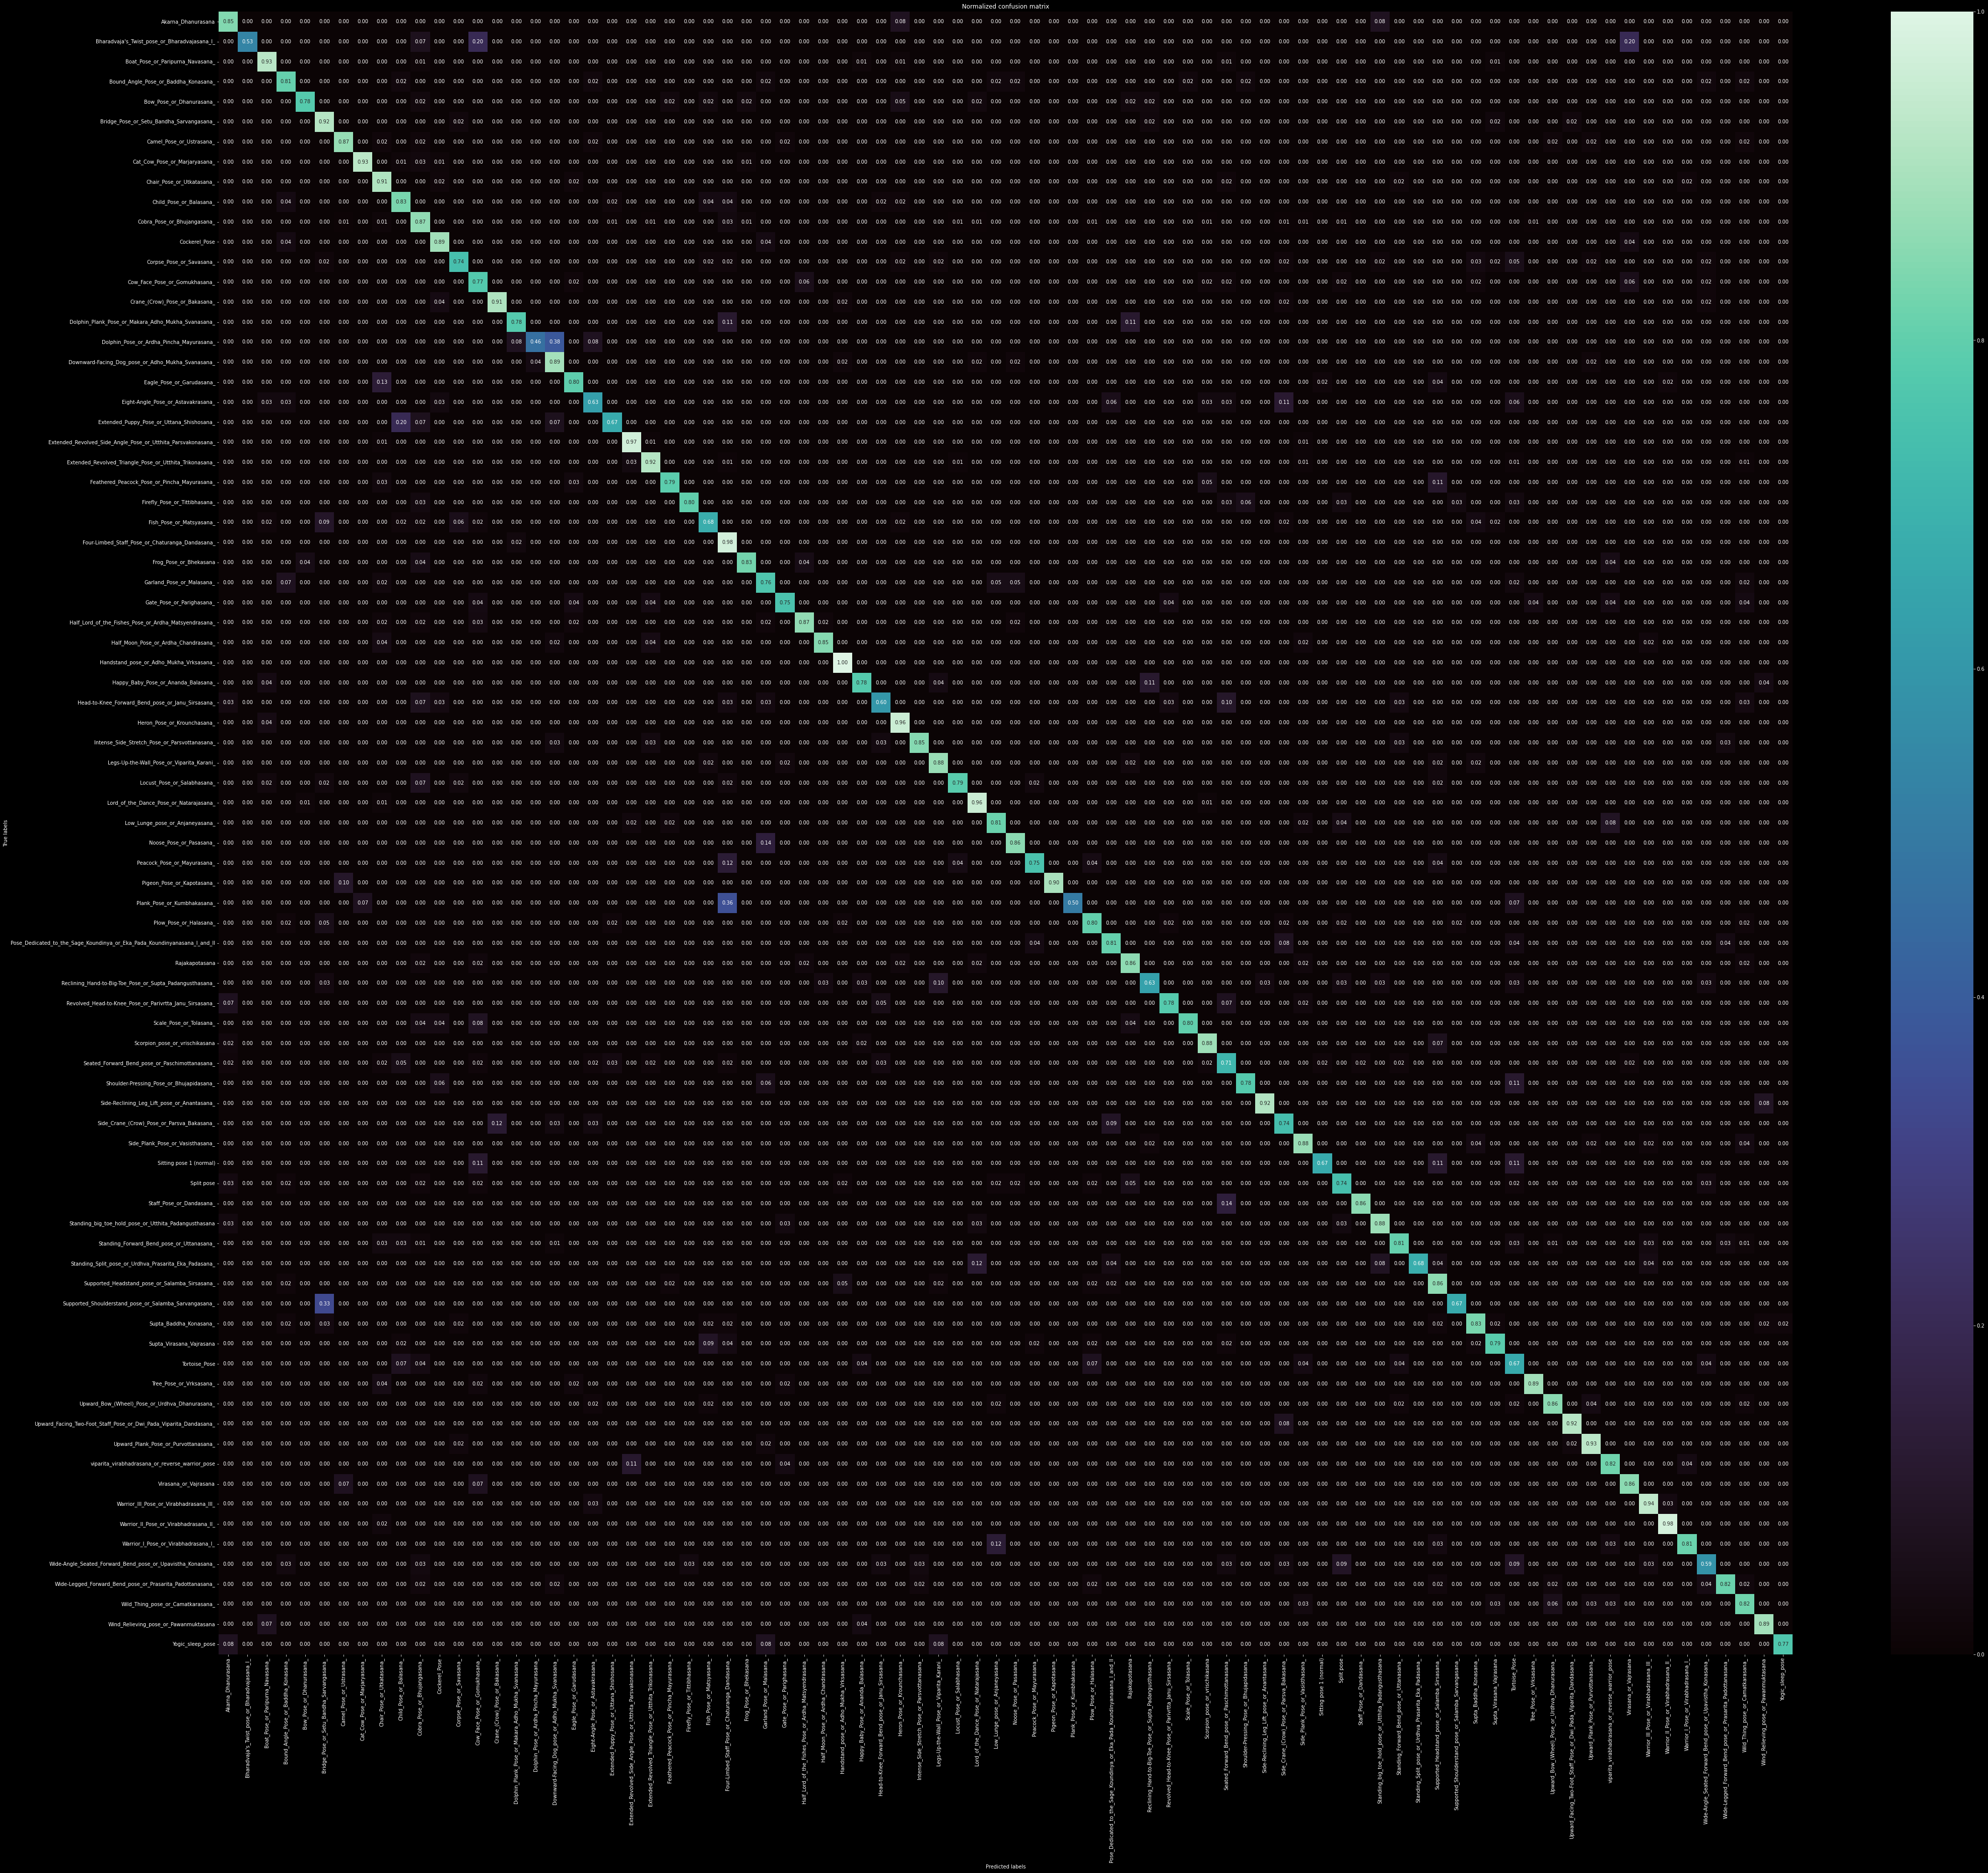

Top 5 worst cases from Confusion Matrix.

percent	true                                                                  pred
0.38	Dolphin_Pose_or_Ardha_Pincha_Mayurasana_                              Downward-Facing_Dog_pose_or_Adho_Mukha_Svanasana_
0.36	Plank_Pose_or_Kumbhakasana_                                           Four-Limbed_Staff_Pose_or_Chaturanga_Dandasana_
0.33	Supported_Shoulderstand_pose_or_Salamba_Sarvangasana_                 Bridge_Pose_or_Setu_Bandha_Sarvangasana_
0.20	Bharadvaja's_Twist_pose_or_Bharadvajasana_I_                          Cow_Face_Pose_or_Gomukhasana_
0.20	Bharadvaja's_Twist_pose_or_Bharadvajasana_I_                          Virasana_or_Vajrasana
0.20	Extended_Puppy_Pose_or_Uttana_Shishosana_                             Child_Pose_or_Balasana_


In [104]:
predicitons = []
true_labels = []

totalVals = len(test_data)
for i in range(totalVals):
    output = model(test_data[i]['input'].to(device))
    predicitons.append(output.argmax(dim=0, keepdim=True))
    true_labels.append(test_data[i]['label'].argmax(dim=0, keepdim=True).to(device))

predicitons = [i.item() for i in predicitons]
true_labels = [i.item() for i in true_labels]

cm = get_confusion_matrix(true_labels, predicitons)
print_worst_cm(cm, 5)

In [ ]:
# Save the model parameters to a file
torch.save(model.state_dict(), 'models/tanh_parameters.pth')

In [ ]:
# Save the model parameters to a file
torch.save(model.state_dict(), 'models/fnn_parameters.pth')

# Define a new instance of the model
model = PoseFFNN(input_dim=69, output_dim=82)

# Load the saved model parameters into the new model
model.load_state_dict(torch.load('models/fnn_parameters.pth'))

In [ ]:
# open the video file
video = cv2.VideoCapture('yoga.mp4')

# initialize an empty list to store the images
images = []

# loop through the video frames
while video.isOpened():
    # read the current frame
    ret, frame = video.read()
    # check if the frame was read successfully
    if ret:
        # append the frame to the images list
        images.append(frame)
    else:
        # break the loop if there are no more frames
        break

# release the video object
video.release()

# print the number of images extracted from the video
print(f"Total images extracted: {len(images)}")

In [ ]:
for i, image in enumerate(images):
    if i % 6 == 0:
        clear_output(wait=True)
        imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = mediaPipe.process(imageRGB)
        if results.pose_landmarks:
            featureVector = center_chest(results.pose_landmarks.landmark)
            plot(featureVector)
            featureVector = torch.Tensor(featureVector.flatten())
            pred = model(featureVector.to(device)).argmax(dim=0, keepdim=True)
            print(poses[pred])
        else:
            print('bad image')

In [ ]:
# Open the default camera
cap = cv2.VideoCapture(0)

# Loop through each frame from the camera
i = 0
while True:

    # Read the current frame
    ret, frame = cap.read()

    # If the frame was read successfully
    if ret:
        i += 1
        if i % 3 == 0:

            clear_output(wait=True)

            imageRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = mediaPipe.process(imageRGB)

            if results.pose_landmarks:
                featureVector = center_chest(results.pose_landmarks.landmark)
                plot(featureVector)
                featureVector = torch.Tensor(featureVector.flatten())
                pred = model(featureVector.to(device)).argmax(dim=0, keepdim=True)
                print(poses[pred])
            else:
                print('bad image')

In [ ]:
cap.release()
cv2.destroyAllWindows()